In [4]:
import pandas_datareader as pdr
import statsmodels.api as sm
import yfinance as yf
import numpy as np
import datetime
import pandas as pd
from statsmodels.regression.rolling import RollingOLS
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters()
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [22]:
def get_stock_log_returns(ticker):
    data = yf.download(ticker, interval='1d', progress=False)['Close']
    data = data.resample('1m').last().iloc[:-1]
    log_returns = np.log(data.pct_change()+1).dropna()
    log_returns = round(log_returns * 100, 2)
    log_returns.name = ticker
    return log_returns

def get_ff_data(data, start='1-1-1960'):
    factor_data = pdr.get_data_famafrench(data, start)[0]
    factor_data.index = (factor_data.index.to_timestamp() + MonthEnd(0)).date
    factor_data.index = pd.to_datetime(factor_data.index)
    return factor_data

def merge_stock_and_ff_data(stock_log_rets, factor_data):
    return pd.concat([stock_log_rets, factor_data], axis=1).dropna()

def gather_stock_factor_data(ticker, factor_data):
    stock_data = get_stock_log_returns(ticker)
    ff_data = get_ff_data(factor_data)
    merged_data = merge_stock_and_ff_data(stock_data, ff_data)
    return merged_data

def rolling_regression(ticker, window=60, factor_data='F-F_Research_Data_5_Factors_2x3', 
                       start_date='1960-01', end_date=datetime.datetime.now().date()):
    merged_data = gather_stock_factor_data(ticker,factor_data=factor_data)
    merged_data = merged_data.loc[start_date:end_date]
    endog = merged_data[ticker] - merged_data.RF.values
    exog_vars = [item for item in list(merged_data.columns) if item not in [ticker, 'RF']]
    exog = sm.add_constant(merged_data[exog_vars])
    rols = RollingOLS(endog, exog, window=window)
    rres = rols.fit()

    print('Most recent (ending) Beta Coefficients\n\n',rres.params.iloc[-1])
    fig = rres.plot_recursive_coefficient(variables=exog_vars, figsize=(10,18))

def point_in_time_regression(ticker='AAPL', factor_data='F-F_Research_Data_5_Factors_2x3',\
                              start_date='1960-01', end_date=datetime.datetime.now().date()):
    merged_data = gather_stock_factor_data(ticker, factor_data)
    merged_data = merged_data.loc[start_date:end_date]
    endog = merged_data[ticker] - merged_data.RF.values
    exog_vars = [item for item in list(merged_data.columns) if item not in [ticker, 'RF']]
    exog = sm.add_constant(merged_data[exog_vars])

    ff_model = sm.OLS(endog, exog, ).fit()
    ff_model = ff_model.get_robustcov_results(cov_type='HAC', maxlags=1)

    print(ff_model.summary())

    # Plot Partial Regression Plot:
    fig = sm.graphics.plot_partregress_grid(ff_model, fig = plt.figure(figsize=(12,8)))
    plt.show()

                            OLS Regression Results                            
Dep. Variable:                   VLUE   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     479.7
Date:                Sun, 03 Dec 2023   Prob (F-statistic):           2.51e-67
Time:                        22:51:26   Log-Likelihood:                -213.93
No. Observations:                 126   AIC:                             435.9
Df Residuals:                     122   BIC:                             447.2
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4870      0.106     -4.584      0.0

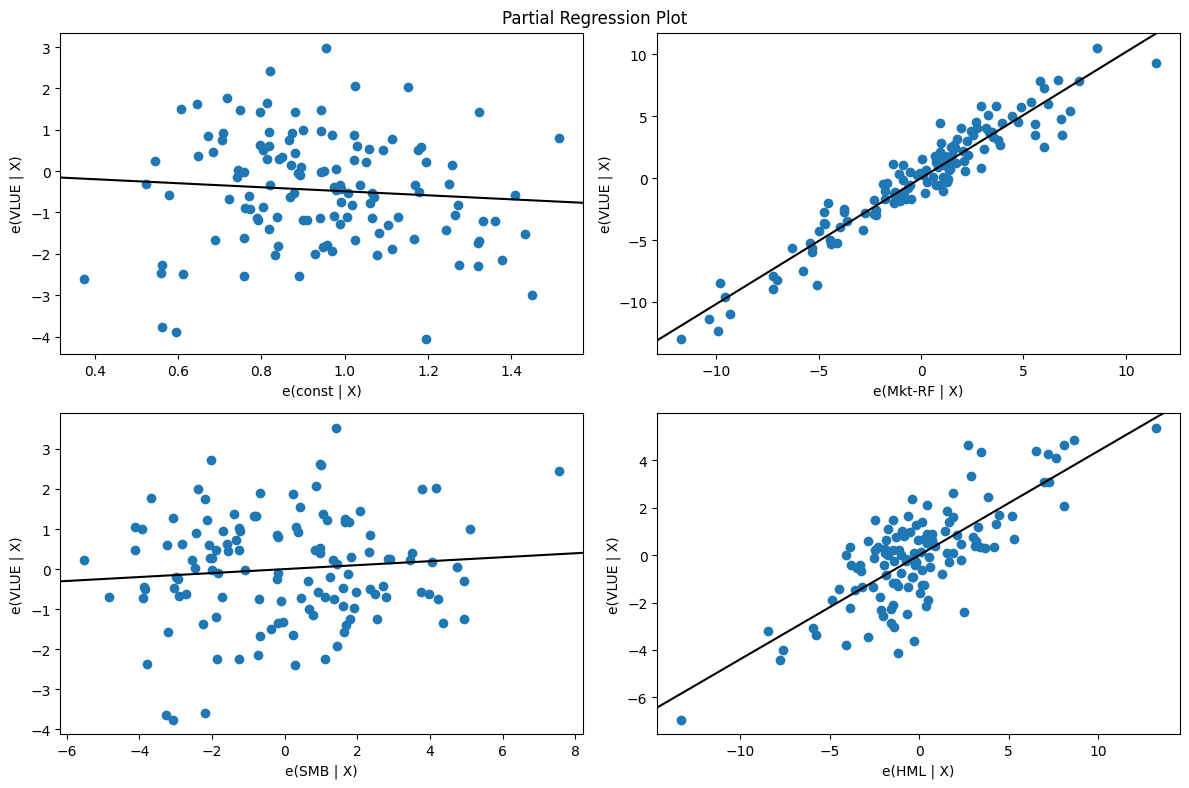

In [14]:
point_in_time_regression(ticker='VLUE', factor_data='F-F_Research_Data_Factors', start_date='2005')

Most recent (ending) Beta Coefficients

 const    -0.755772
Mkt-RF    0.997614
SMB       0.142056
HML       0.500802
Name: 2023-10-31 00:00:00, dtype: float64


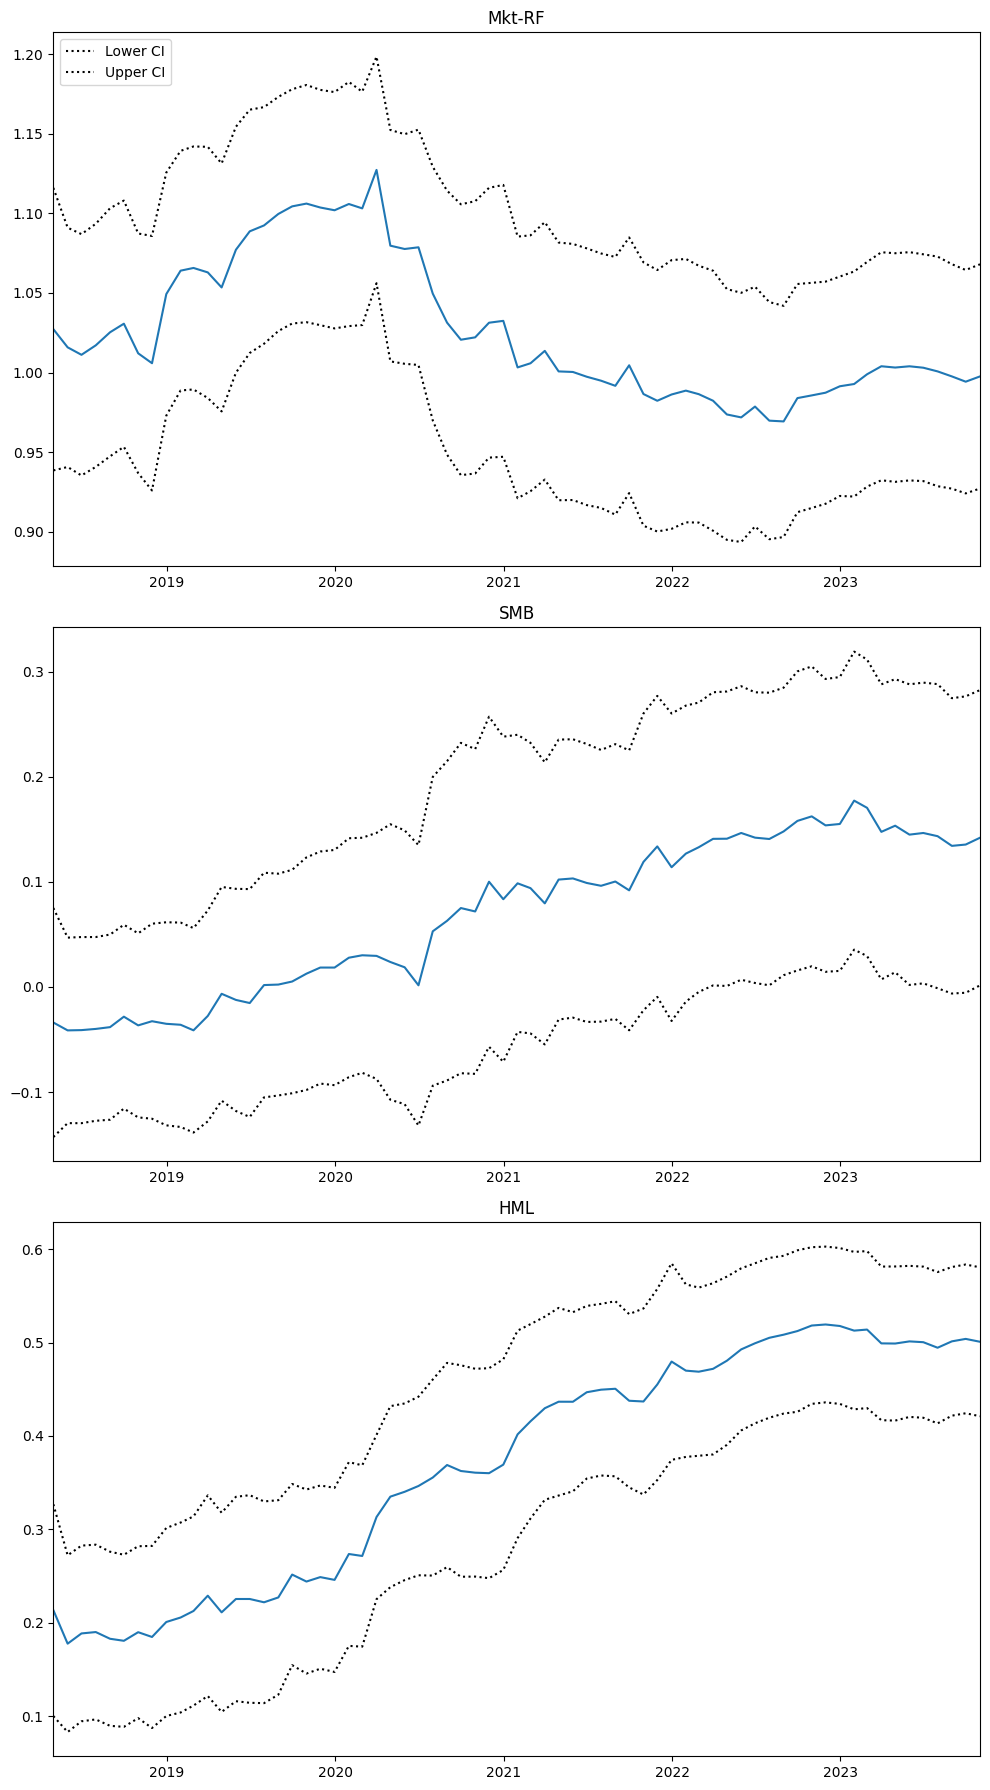

In [23]:
rolling_regression('VLUE', factor_data='F-F_Research_Data_Factors', start_date='2005')